# Regression

In [4]:
### --- Dependencies --- ###
from importlib import reload
import definitions as df
import torch
from tqdm import tqdm
import datetime
import importlib
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import datetime
import os
import solvers
importlib.reload(solvers)

torch.set_default_dtype(torch.float64)

reload(df)


# parser = argparse.ArgumentParser(description='PyTorch NTK Uncertainty Estimate Experiment')
# parser.add_argument('--dataset',default='cifar',type=str,help='dataset (cifar or imagenet)')
# args = parser.parse_args()

### --- CONSTANTS --- ###
dataset_str = 'concrete'
TRAIN_RATIO = 0.9
BATCH_SIZE = 100
NORMALIZE_X = True
NORMALIZE_Y = True
LAYER_WIDTH = 150
NTK_WEIGHT_INIT = True

NTK_MODEL_PATH = "./model_chkpt/ntk_network.pt"
ENSEMBLE_MODEL_PATH = "./model_chkpt/ensemble_networks.pt"

learning_rate = 1e-2
epochs = 4000

ensemble_M = 5

FIND_MAN_KAPPA = False
REPORT_KAPPA = False
FIND_FUNC_JAX_KAPPA = True
KAPPA_COMPARISON = FIND_MAN_KAPPA and FIND_FUNC_JAX_KAPPA

type_solve = 'iterative'
rtol_solve = 1e-15
maxit_solve = 10000

### --- INPUT DATA HERE AS WELL AS DATASET NAME --- ###
if dataset_str == 'energy':
    data = pd.read_excel('.\data\Energy\ENB2012_data.xlsx')
    num_features = 8
elif dataset_str == 'concrete':
    data = pd.read_excel('.\data\Concrete\Concrete_Data.xls')
    num_features = 8

# print(data.shape)
print("--- Loading dataset {} --- \n".format(dataset_str))
print("Number of data points = {}".format(len(data)))
print("Number of coloumns = {}".format(len(data.columns)))
print("Number of features = {}".format(num_features))

training_set, test_set = df.data_split(data,TRAIN_RATIO)

if NORMALIZE_X:
    train_mX = training_set[:,:num_features].mean(axis=0)
    train_sX = training_set[:,:num_features].std(axis=0)
    train_sX[train_sX==0]=1
else:
    train_mX = 0
    train_sX = 1

if NORMALIZE_Y:
    train_my = training_set[:,num_features].mean(axis=0)
    train_sy = training_set[:,num_features].std(axis=0)
    if train_sy==0:
        train_sy=1
else:
    train_my = 0
    train_sy = 1

train_dataset = df.RegressionDataset(training_set, input_dim=num_features, mX=train_mX, sX=train_sX, my=train_my, sy=train_sy)
test_dataset = df.RegressionDataset(test_set, input_dim=num_features, mX=train_mX, sX=train_sX)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_set), shuffle=False)

np.set_printoptions(suppress=True, precision=4)
print("\n Sample training point \n X: {}, \n y: {} \n".format(train_dataset.__getitem__(0)[0], train_dataset.__getitem__(0)[1]))
print("Sample test point \n X: {}, \n y: {} ".format(test_dataset.__getitem__(0)[0], test_dataset.__getitem__(0)[1]))

--- Loading dataset concrete --- 

Number of data points = 1030
Number of coloumns = 9
Number of features = 8
training set has shape (927, 9) 

test set has shape (103, 9)

 Sample training point 
 X: tensor([ 0.6513, -0.8635, -0.8516,  0.4790, -1.0481,  0.9385,  0.4240,  4.9267]), 
 y: 0.3623727955207817 

Sample test point 
 X: tensor([ 0.0656,  1.3639, -0.8516,  0.4790, -1.0481, -0.5261, -0.6713, -0.2809]), 
 y: 38.804398756000005 


In [5]:
learning_rate = 1e-2
epochs = 400

## Create Model
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ntk_network = df.MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(df.weights_init)
print("Number of parameters in NTK network = {}".format(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

## Train NTK network
mse_loss = nn.MSELoss(reduction='mean')
ntk_optimizer = df.optimizer_shared(ntk_network, type='adam', learning_rate=learning_rate)
ntk_scheduler = optim.lr_scheduler.StepLR(ntk_optimizer,epochs/4,gamma=0.5)

# Run the training loop
print("\n Training NTK network \n")
for epoch in tqdm(range(epochs)):
    ntk_train_mse  = df.training_loop_ntk(
        dataloader=train_loader,
        model=ntk_network, 
        optimizer=ntk_optimizer,
        loss_function=mse_loss,
        verbose=False)
    
    ntk_test_mse, ntk_test_rel_error = df.test_loop_ntk(
        dataloader=test_loader,
        model = ntk_network,
        my=train_my,
        sy=train_sy,
        loss_function=mse_loss)
    
    ntk_scheduler.step()

    if epoch % int(epochs/4) == 0:
        print("Epoch {} of {}".format(epoch,epochs))
        print("Training MSE = {:.3f}".format(ntk_train_mse))
        print("Test MSE = {:.2f}".format(ntk_test_mse))
        print("Learning rate = {}".format(ntk_scheduler.get_last_lr()))
    
# Process is complete.
print('\n NTK Training process has finished.')
print("Final training MSE = {:.3f}".format(ntk_train_mse))
print("Final test MSE = {:.2f}".format(ntk_test_mse))

torch.save({
    'model': ntk_network.state_dict(),
    'train_mse': ntk_train_mse,
    'test_mse': ntk_test_mse,
    'test_rel_err': ntk_test_rel_error
    },
    NTK_MODEL_PATH)

## 
ensemble_model_list = []
ensemble_model_state_list = []
ensemble_opt_list = []
ensemble_sched_list = []
ensemble_mse_training_list = np.empty(ensemble_M)
ensemble_mse_test_list = np.empty(ensemble_M)
ensemble_nll_list = np.empty(ensemble_M)
ensemble_rel_err_test_list = np.empty((ensemble_M,len(test_dataset)))

NLL = df.CustomNLL()
for i in range(ensemble_M):
    ensemble_model_list.append(df.EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_opt_list.append(df.optimizer_shared(ensemble_model_list[i], type='adam', learning_rate=learning_rate))
    ensemble_sched_list.append(optim.lr_scheduler.StepLR(ensemble_opt_list[i],epochs/4,gamma=0.5))

for i in range(ensemble_M):
    print(f"\n Training ensemble {i+1} ")
    for epoch in tqdm(range(epochs)):
        ensemble_train_mse = df.training_loop_ensemble(
            dataloader=train_loader, 
            model=ensemble_model_list[i], 
            optimizer=ensemble_opt_list[i], 
            loss_function=NLL,
            mse_loss= mse_loss,
            verbose=False)
        
        ensemble_test_mse, ensemble_test_nll, ensemble_test_rel_err = df.test_loop_ensemble(
            dataloader=test_loader, 
            model=ensemble_model_list[i], 
            my=train_my, 
            sy=train_sy, 
            mse_loss=mse_loss,
            loss_function=NLL)
        
        ensemble_sched_list[i].step()
        
        if epoch % (epochs/4) == 0:
            print("Epoch {} of {}".format(epoch,epochs))
            print("Training MSE = {:.3f}".format(ensemble_train_mse))
            print("Test MSE = {:.2f}".format(ensemble_test_mse))
            print("Learning rate = {}".format(ensemble_sched_list[i].get_last_lr()))

    print("Done!")
    ensemble_mse_training_list[i] = ensemble_train_mse
    ensemble_mse_test_list[i] = ensemble_test_mse
    ensemble_nll_list[i] = ensemble_test_nll
    ensemble_rel_err_test_list[i,:] = ensemble_test_rel_err.detach().numpy().squeeze(1)
print('\n Ensemble training process has finished.')

## Print training metrics
print("Final ntk training MSE = {:.4f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

for i in range(ensemble_M):
    ensemble_model_state_list.append(ensemble_model_list[i].state_dict())

torch.save({
    'models': ensemble_model_state_list,
    'train_mse': ensemble_mse_training_list,
    'test_mse': ensemble_mse_test_list,
    'test_nll': ensemble_nll_list,
    'test_rel_err': ensemble_rel_err_test_list
    },
    ENSEMBLE_MODEL_PATH)

print("Model saved!")

Using cpu device
Number of parameters in NTK network = 92101

 Training NTK network 



  1%|          | 3/400 [00:00<00:16, 24.21it/s]

Epoch 0 of 400
Training MSE = 1.480
Test MSE = 194.67
Learning rate = [0.01]


 26%|██▌       | 103/400 [00:03<00:10, 27.53it/s]

Epoch 100 of 400
Training MSE = 0.024
Test MSE = 11.76
Learning rate = [0.005]


 51%|█████▏    | 205/400 [00:07<00:07, 27.57it/s]

Epoch 200 of 400
Training MSE = 0.014
Test MSE = 10.98
Learning rate = [0.0025]


 76%|███████▌  | 304/400 [00:11<00:03, 27.45it/s]

Epoch 300 of 400
Training MSE = 0.008
Test MSE = 10.11
Learning rate = [0.00125]


100%|██████████| 400/400 [00:14<00:00, 26.81it/s]



 NTK Training process has finished.
Final training MSE = 0.007
Final test MSE = 11.27

 Training ensemble 1 


  1%|          | 3/400 [00:00<00:14, 27.92it/s]

Epoch 0 of 400
Training MSE = 0.683
Test MSE = 115.99
Learning rate = [0.01]


 26%|██▋       | 105/400 [00:03<00:09, 30.59it/s]

Epoch 100 of 400
Training MSE = 0.037
Test MSE = 13.62
Learning rate = [0.005]


 52%|█████▏    | 206/400 [00:06<00:06, 29.88it/s]

Epoch 200 of 400
Training MSE = 0.019
Test MSE = 11.69
Learning rate = [0.0025]


 77%|███████▋  | 307/400 [00:10<00:03, 30.38it/s]

Epoch 300 of 400
Training MSE = 0.010
Test MSE = 11.09
Learning rate = [0.00125]


100%|██████████| 400/400 [00:13<00:00, 30.01it/s]


Done!

 Training ensemble 2 


  1%|          | 3/400 [00:00<00:13, 28.52it/s]

Epoch 0 of 400
Training MSE = 0.778
Test MSE = 124.05
Learning rate = [0.01]


 26%|██▌       | 104/400 [00:03<00:09, 30.51it/s]

Epoch 100 of 400
Training MSE = 0.031
Test MSE = 10.81
Learning rate = [0.005]


 51%|█████     | 204/400 [00:06<00:06, 30.65it/s]

Epoch 200 of 400
Training MSE = 0.015
Test MSE = 11.95
Learning rate = [0.0025]


 76%|███████▋  | 306/400 [00:10<00:03, 30.52it/s]

Epoch 300 of 400
Training MSE = 0.010
Test MSE = 11.93
Learning rate = [0.00125]


100%|██████████| 400/400 [00:13<00:00, 30.12it/s]


Done!

 Training ensemble 3 


  1%|          | 3/400 [00:00<00:13, 29.18it/s]

Epoch 0 of 400
Training MSE = 0.668
Test MSE = 98.79
Learning rate = [0.01]


 26%|██▌       | 104/400 [00:03<00:09, 30.28it/s]

Epoch 100 of 400
Training MSE = 0.040
Test MSE = 15.89
Learning rate = [0.005]


 51%|█████     | 204/400 [00:06<00:06, 30.69it/s]

Epoch 200 of 400
Training MSE = 0.018
Test MSE = 10.41
Learning rate = [0.0025]


 77%|███████▋  | 307/400 [00:10<00:03, 30.69it/s]

Epoch 300 of 400
Training MSE = 0.010
Test MSE = 12.12
Learning rate = [0.00125]


100%|██████████| 400/400 [00:13<00:00, 30.18it/s]


Done!

 Training ensemble 4 


  1%|          | 3/400 [00:00<00:13, 28.55it/s]

Epoch 0 of 400
Training MSE = 0.912
Test MSE = 170.62
Learning rate = [0.01]


 27%|██▋       | 107/400 [00:03<00:09, 29.62it/s]

Epoch 100 of 400
Training MSE = 0.033
Test MSE = 13.05
Learning rate = [0.005]


 52%|█████▏    | 207/400 [00:06<00:06, 30.61it/s]

Epoch 200 of 400
Training MSE = 0.017
Test MSE = 10.83
Learning rate = [0.0025]


 77%|███████▋  | 307/400 [00:10<00:03, 30.42it/s]

Epoch 300 of 400
Training MSE = 0.010
Test MSE = 9.27
Learning rate = [0.00125]


100%|██████████| 400/400 [00:13<00:00, 30.25it/s]


Done!

 Training ensemble 5 


  1%|          | 3/400 [00:00<00:13, 29.11it/s]

Epoch 0 of 400
Training MSE = 0.908
Test MSE = 135.99
Learning rate = [0.01]


 26%|██▌       | 104/400 [00:03<00:09, 30.19it/s]

Epoch 100 of 400
Training MSE = 0.053
Test MSE = 17.89
Learning rate = [0.005]


 51%|█████     | 204/400 [00:06<00:06, 30.60it/s]

Epoch 200 of 400
Training MSE = 0.019
Test MSE = 11.68
Learning rate = [0.0025]


 76%|███████▋  | 305/400 [00:10<00:03, 30.02it/s]

Epoch 300 of 400
Training MSE = 0.012
Test MSE = 11.88
Learning rate = [0.00125]


100%|██████████| 400/400 [00:13<00:00, 30.01it/s]

Done!

 Ensemble training process has finished.
Final ntk training MSE = 0.0071
Final ntk test MSE = 11.27
Final ensemble training MSE = [0.0085 0.009  0.0141 0.01   0.0109]
Final ensemble test MSE = [11.0753 12.0966 12.4361  9.2624 11.4245]
Model saved!


Using cpu device
Loading models:
Models loaded.


C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version o


 --- Finding uncertainty estimates --- 

Norm of residual array (y-f) = 2.4799994944998165
Norm of resid_solve = 62879.9195620328


100%|██████████| 103/103 [01:12<00:00,  1.43it/s]

Finished! 

Number of zero values uncertainty array: 0
Number of negative values for full rank: 2

 --- Plotting Results --- 



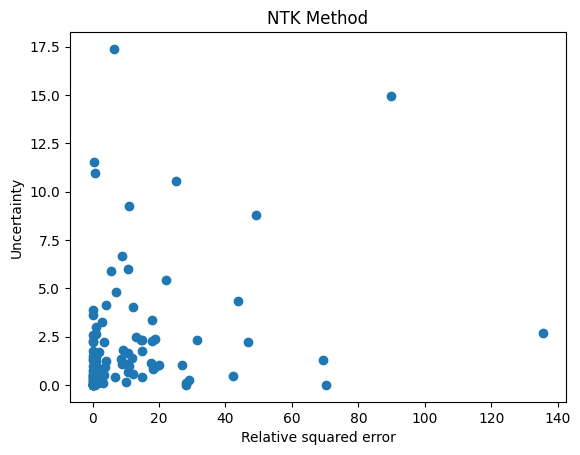

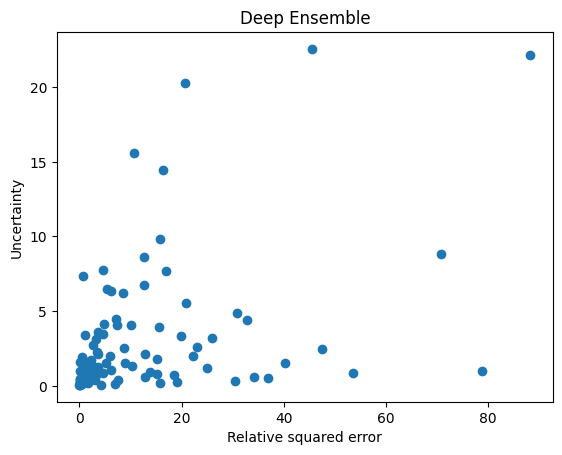

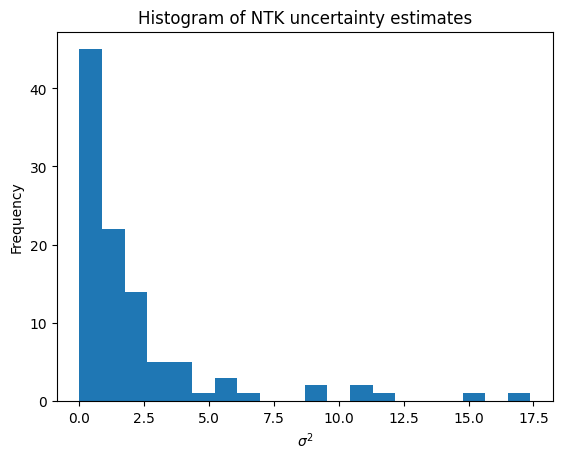

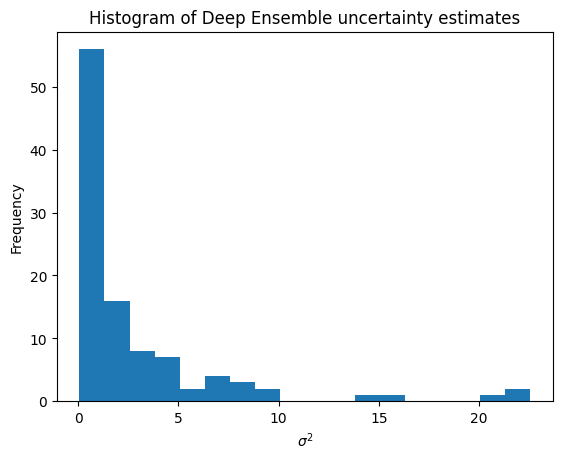

c:\Users\s4531973\Documents\PhD\Code\Uncertainty Quantification\definitions.py:332: RuntimeWarning: invalid value encountered in sqrt
  ci_c = z * np.sqrt(uncertainties*(sy**2))


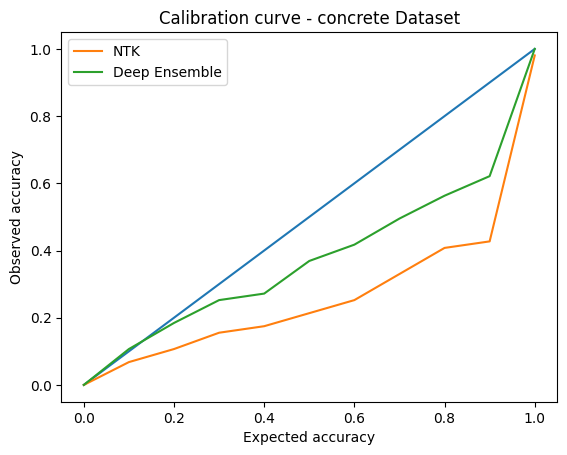

Final ntk training MSE = 0.007
Final ntk test MSE = 11.27
Final ensemble training MSE = [0.0085 0.009  0.0141 0.01   0.0109]
Final ensemble test MSE = [11.0753 12.0966 12.4361  9.2624 11.4245]


In [9]:
type_solve = 'iterative'
rtol_solve = 1e-13
maxit_solve = 4000



# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## load models
print("Loading models:")

# Load NTK Model
ntk_saved_model = torch.load(NTK_MODEL_PATH)

ntk_network = df.MLP(input_d=num_features,width=LAYER_WIDTH).to(device=device, dtype=torch.float64)
if NTK_WEIGHT_INIT:
    ntk_network.apply(df.weights_init)
ntk_network.load_state_dict(ntk_saved_model['model'])
ntk_network.eval()

ntk_train_mse = ntk_saved_model['train_mse']
ntk_test_mse = ntk_saved_model['test_mse']
ntk_test_rel_error = ntk_saved_model['test_rel_err']

# Load Ensemble Models
ensemble_saved_models = torch.load(ENSEMBLE_MODEL_PATH)

ensemble_model_list = []
for i in range(ensemble_M):
    ensemble_model_list.append(df.EnsembleNetwork(input_d=num_features, width=LAYER_WIDTH).to(device=device,dtype=torch.float64))
    ensemble_model_list[i].load_state_dict(ensemble_saved_models['models'][i])
    ensemble_model_list[i].eval()

ensemble_mse_training_list = ensemble_saved_models['train_mse']
ensemble_mse_test_list = ensemble_saved_models['test_mse']
ensemble_nll_list = ensemble_saved_models['test_nll']
ensemble_rel_err_test_list = ensemble_saved_models['test_rel_err']

print("Models loaded.")

### --- NTK --- ###
if FIND_MAN_KAPPA:
    EPSILON = 0
    print("\n --- Finding Kappa --- \n")
    kappa_man_time_start = time.time()
    Kappa_man = df.ntk_matrix(train_dataset,train_dataset,model=ntk_network,optimizer=ntk_optimizer)
    kappa_man_time_end = time.time()
    kappa_man_time = kappa_man_time_end - kappa_man_time_start
    eigvals = np.linalg.eigvalsh(Kappa_man)

if FIND_FUNC_JAX_KAPPA:
    kappa_jax_time_start = time.time()
    Kappa = df.empirical_ntk(
        model=ntk_network,
        dataset1=train_dataset,
        dataset2=train_dataset
    )
    Kappa_jax = Kappa.detach().numpy().squeeze((2,3))
    kappa_jax_time_end = time.time()
    kappa_jax_time = kappa_jax_time_end - kappa_jax_time_start
    eigvals = np.linalg.eigvalsh(Kappa_jax)

if REPORT_KAPPA:
    print("\n--- Kappa (Manual) Summary --- \n")
    print("Condition number of Kappa = {:.2f}".format(np.linalg.cond(Kappa)))
    eigvals = np.linalg.eigvalsh(Kappa)
    print("Number of negative eigenvalues of Kappa = {}".format(eigvals[eigvals<0].size))
    print("Number of zero eigenvalues of Kappa = {}".format(eigvals[eigvals==0].size))
    print("Smallest eigenvalue is = {}".format(sorted(eigvals)[0]))

if KAPPA_COMPARISON:

    man_eigvals = np.linalg.eigvalsh(Kappa_man)
    jax_eigvals = np.linalg.eigvalsh(Kappa_jax)

    plot_dir = "./ntk_conditioning_results/"
    results_name = "results.txt"
    with open(plot_dir+results_name,'w') as results:
        results.write("{} \n".format(datetime.datetime.now()))
        results.write("Manual method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {}, \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_man_time,
                                                     np.linalg.cond(Kappa_man),
                                                        man_eigvals[man_eigvals<0].size,
                                                        sorted(man_eigvals)[0])
        )
        results.write("\n PyTorch JAX method: \n\
                    Method time elapsed = {} seconds\n \
                    Condition number = {} \n\
                    Num negative eigvals = {} \n\
                    Smallest eigval = {}. \n".format(kappa_jax_time,
                                                     np.linalg.cond(Kappa_jax),
                                                        jax_eigvals[jax_eigvals<0].size,
                                                        sorted(jax_eigvals)[0])
        )
        results.write("Frobenius norm difference between two methods = {}".format(
            np.linalg.norm(Kappa_man-Kappa_jax)
        ))

### --- Current Kappa --- ###
        
Kappa = Kappa_jax

## Uncertainty Quantification
print("\n --- Finding uncertainty estimates --- \n")
uncert_time_start = time.time()
uncertainty_array, solver_info, uncertainty_array_lifted, mu = df.ntk_uncertainty_explicit(
    Kappa=Kappa, 
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=ntk_network,
    type=type_solve,
    rtol=rtol_solve,
    maxit=maxit_solve,
    epsilon=0.000001)
uncert_time_end = time.time()
uncert_time = uncert_time_end-uncert_time_start # (seconds)
solver_info_mean = np.mean(solver_info,axis=1)
print("Finished! \n")
print("Number of zero values uncertainty array: {}".format(uncertainty_array[uncertainty_array==0].size))
print("Number of negative values for full rank: {}".format(uncertainty_array[uncertainty_array<0].size))

uncertainty_array = uncertainty_array / np.sqrt(sum(p.numel() for p in ntk_network.parameters() if p.requires_grad))

mu_mean, sigma_mean = df.ensemble_result(
    test_loader=test_loader,
    ensemble_M=ensemble_M,
    model_list=ensemble_model_list,
    sy=train_sy,
    my=train_my
)
ensemble_rel_err_test_list = np.mean(ensemble_rel_err_test_list,axis=0)

### --- Plot results --- ###
print("\n --- Plotting Results --- \n")
today = datetime.date.today()
now = datetime.datetime.now()
# plot_dir = "./data/{}/{}/plot/".format(dataset_str, today.strftime("%d_%m_%Y"))
plot_dir = "./data/{}/{}/plot/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)

## NTK Scatter
plot_name = "ntk_scatter.pdf"
plt.scatter(ntk_test_rel_error, uncertainty_array*(train_sy**2))
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("NTK Method")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

# ## NTK Lifted Scatter
# plot_name = "ntk_lifted_scatter.pdf"
# plt.scatter(ntk_test_rel_error, uncertainty_array_lifted*(train_sy**2))
# plt.xlabel("Relative squared error")
# plt.ylabel("Uncertainty")
# plt.title("NTK Lifted Method")
# plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
# plt.show()

## Deep Ensemble scatter
plot_name = "ensemble_scatter.pdf"
plt.scatter(ensemble_rel_err_test_list, sigma_mean)
plt.xlabel("Relative squared error")
plt.ylabel("Uncertainty")
plt.title("Deep Ensemble")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

## NTK Histogram
plot_name = "ntk_hist.pdf"
plt.hist(sorted((train_sy**2)*uncertainty_array.squeeze(0)), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of NTK uncertainty estimates")
plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
plt.show()

# ## NTK Lifted Histogram
# plot_name = "ntk_lifted_hist.pdf"
# plt.hist(sorted((train_sy**2)*uncertainty_array_lifted.squeeze(0)), bins='auto')
# plt.xlabel("$\sigma^2$")
# plt.ylabel("Frequency")
# plt.title("Histogram of NTK Lifted uncertainty estimates")
# plt.savefig(plot_dir + plot_name, format="pdf", bbox_inches="tight")
# plt.show()

## Deep Ensemble Histogram
plot_name = "ensemble_hist.pdf"
plt.hist(sorted(sigma_mean), bins='auto')
plt.xlabel("$\sigma^2$")
plt.ylabel("Frequency")
plt.title("Histogram of Deep Ensemble uncertainty estimates")
plt.savefig(plot_dir + plot_name.format(dataset_str), format="pdf", bbox_inches="tight")
plt.show()

### --- Plot calibration curve --- ###

plot_name = "calibration_curve.pdf"
observed_true_ntk = df.calibration_curve_ntk(
    testloader=test_loader, 
    uncertainties=uncertainty_array, 
    model=ntk_network, 
    num_c=11, 
    my=train_my, 
    sy=train_sy)
observed_true_ensemble = df.calibration_curve_ensemble(
    testloader=test_loader, 
    mu=mu_mean, 
    sigma2=sigma_mean, 
    num_c=11)
df.plot_calibration(
    observed_true_ntk=observed_true_ntk, 
    observed_true_ensemble=observed_true_ensemble, 
    dataset_str=dataset_str, 
    dir_name=plot_dir, 
    plot_name=plot_name)

# ### --- Plot calibration curve (lifted) --- ###

# plot_name = "calibration_curve_lifted.pdf"
# observed_true_ntk = df.calibration_curve_ntk(
#     testloader=test_loader, 
#     uncertainties=uncertainty_array_lifted, 
#     model=ntk_network, 
#     num_c=11, 
#     my=train_my, 
#     sy=train_sy)
# observed_true_ensemble = df.calibration_curve_ensemble(
#     testloader=test_loader, 
#     mu=mu_mean, 
#     sigma2=sigma_mean, 
#     num_c=11)
# df.plot_calibration(
#     observed_true_ntk=observed_true_ntk, 
#     observed_true_ensemble=observed_true_ensemble, 
#     dataset_str=dataset_str, 
#     dir_name=plot_dir, 
#     plot_name=plot_name)

result_dir = "./data/{}/{}/result/".format(dataset_str, now.strftime("%d_%m_%Y__%H_%M_%S"))
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)

print("Final ntk training MSE = {:.3f}".format(ntk_train_mse))
print("Final ntk test MSE = {:.2f}".format(ntk_test_mse))
print("Final ensemble training MSE = {}".format(ensemble_mse_training_list))
print("Final ensemble test MSE = {}".format(ensemble_mse_test_list))

results_name = "results.txt"
with open(result_dir+results_name,'w') as results:
    results.write("--- Dataset & Model --- \n")
    results.write("Number of training points = {} \n".format(len(training_set)))
    results.write("Number of test points = {} \n".format(len(test_set)))
    results.write("Number of features = {} \n".format(num_features))
    results.write("Number of hidden layers = {} \n".format(4))
    results.write("Width of hidden layer = {} \n".format(LAYER_WIDTH))
    results.write("Number of parameters in NTK network = {} \n".format(
        sum(p.numel() for p in ntk_network.parameters() if p.requires_grad)))

    results.write("\n --- Results --- \n")
    results.write("Final ntk training mse = {:.3f} \n".format(ntk_train_mse))
    results.write("Final ntk test mse = {:.2f} \n".format(ntk_test_mse))
    results.write("Deep Ensemble training mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_training_list),np.std(ensemble_mse_training_list)))
    results.write("Deep Ensemble test mse: mean = {:.2f}, std = {:.2f} \n".format(np.mean(ensemble_mse_test_list),np.std(ensemble_mse_test_list)))
    results.write("Deep Ensemble NLL: mean = {:.2f}, std {:.2f} \n".format(np.mean(ensemble_nll_list),np.std(ensemble_nll_list)))
    results.write("\n --- Training Details --- \n")
    results.write("Learning Rate = {} \n".format(learning_rate))
    results.write("Training Epochs = {} \n".format(epochs))
    results.write("Number of ensembles = {} \n".format(ensemble_M))

    results.write("\n --- NTK Method Details --- \n")
    results.write("Condition number of Kappa = {:.2f} \n".format(np.linalg.cond(Kappa)))
    results.write("Number of negative eigenvalues of Kappa = {} \n".format(eigvals[eigvals<0].size))
    results.write("Number of zero eigenvalues of Kappa = {} \n".format(eigvals[eigvals==0].size))

    results.write("\n --- Uncertainty Solution Details --- \n")
    results.write("Type of linear solver = {} \n".format(type_solve))
    if type_solve=='iterative':
        results.write("Time to solve all test examples = {:.2f} seconds \n".format(uncert_time))
        results.write("Tolerance of solver = {} \n".format(rtol_solve))
        results.write("Max iteration of solver = {} \n".format(maxit_solve))
        results.write("Average solver iter = {} \n".format(solver_info_mean[0]))
        results.write("Average solver resid error = {} \n".format(solver_info_mean[1]))
        results.write("Average solver matrix resid error = {} \n".format(solver_info_mean[2]))
    results.write("\n Number of negative values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array<0].size))
    results.write("Number of zero values in NTK uncertainties array: {} \n".format(uncertainty_array[uncertainty_array==0].size))


In [8]:
test_dataloader = DataLoader(test_dataset,len(test_dataset))
X_test,y_test = next(iter(test_dataloader))
x_hat = ntk_network(X_test)

In [9]:
mu_t = torch.from_numpy(mu).reshape(-1,1)
x_hat = x_hat
y_test = y_test.reshape(-1,1)
print("Sizes are {},{},{}".format(mu_t.shape,x_hat.shape,y_test.shape))
mse_loss = nn.MSELoss(reduction='mean')
print(mse_loss(x_hat*train_sy+train_my,y_test))
print(mse_loss(mu_t*train_sy+train_my,y_test))
print(torch.norm(mu_t-x_hat))
# print(mu_t*train_sy+train_my)
# print(x_hat*train_sy+train_my)


Sizes are torch.Size([77, 1]),torch.Size([77, 1]),torch.Size([77, 1])
tensor(0.5901, grad_fn=<MseLossBackward0>)
tensor(253.3689)
tensor(14.3192, grad_fn=<LinalgVectorNormBackward0>)


# Classification

In [1]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets
from tqdm import tqdm
import definitions as df
from importlib import reload
import definitions as df
import torch
from tqdm import tqdm
import importlib
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import solvers
importlib.reload(solvers)

torch.set_default_dtype(torch.float64)

reload(df)

N_TRAIN = 1000
N_TEST = 100
N_OUTPUT = 10
learning_rate = 1e-1
batch_size = 50
epochs = 50

training_data = datasets.MNIST(
    root="data/MNIST",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data/MNIST",
    train=False,
    download=True,
    transform=ToTensor()
)

training_data = torch.utils.data.Subset(training_data,range(N_TRAIN))
test_data = torch.utils.data.Subset(test_data,range(N_TEST))
 
cnn = df.CNN()
print("Number of parameters p = {}".format(sum(p.numel() for p in cnn.parameters() if p.requires_grad)))

train_dataloader = DataLoader(training_data, batch_size)
test_dataloader = DataLoader(test_data, N_TEST)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)

for t in tqdm(range(epochs)):
    cnn_train_ce = df.train_loop(train_dataloader, cnn, loss_fn, optimizer)
    cnn_test_ce, cnn_test_acc = df.test_loop(test_dataloader, cnn, loss_fn)
print("Done!")
print("Final cnn training cross-entropy = {:.3f}".format(cnn_train_ce))
print("Final cnn test cross-entropy = {:.2f}".format(cnn_test_ce))
print("Final cnn test accuracy = {:.1f}%".format(100*cnn_test_acc))

Number of parameters p = 1301


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]

Done!
Final cnn training cross-entropy = 0.061
Final cnn test cross-entropy = 0.26
Final cnn test accuracy = 91.0%


In [2]:
from functorch import make_functional

fnet, params = make_functional(cnn)     

def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0) 

dataset1_ntk = DataLoader(training_data,len(training_data))
x1_ntk,_ = next(iter(dataset1_ntk))
dataset2_ntk = DataLoader(training_data,len(training_data))
x2_ntk,_ = next(iter(dataset2_ntk))
test_dataloader = DataLoader(test_data,len(test_data))
x1_test,_ = next(iter(test_dataloader))

print("Test shape is {}".format(x1_test.shape))

Kappa_c = df.empirical_ntk_jacobian_contraction_c(fnet_single, params, x1_ntk, x2_ntk,c=1)
Kappa = df.empirical_ntk_jacobian_contraction(fnet_single, params, x1_ntk, x2_ntk)
# kappa_xx = df.empirical_ntk_jacobian_contraction_c(fnet_single=fnet_single,params=params,x1=x1_test,x2=x1_test,c=0)
kappa_xX_c = df.empirical_ntk_jacobian_contraction_c(fnet_single=fnet_single,params=params,x1=x1_test,x2=x2_ntk,c=0)
kappa_xX = df.empirical_ntk_jacobian_contraction(fnet_single=fnet_single,params=params,x1=x1_test,x2=x2_ntk)
print(Kappa.shape)
print(Kappa_c.shape)
# print(kappa_xx.shape)
# print(kappa_xX.shape)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version o

Test shape is torch.Size([100, 1, 28, 28])
torch.Size([1000, 200])
torch.Size([1000, 10, 200])
torch.Size([100, 200])
torch.Size([100, 10, 200])
torch.Size([1000, 1000, 10, 10])
torch.Size([1000, 1000])


In [16]:
print(torch.norm(kappa_xX[:,:,0,0]-kappa_xX_c))

tensor(6.7744e-12, grad_fn=<LinalgVectorNormBackward0>)


In [2]:
rtol_solve = 1e-5
maxit_solve = 50

uncertainty_array = df.ntk_uncertainty_explicit_class(
    train_dataset=training_data,
    test_dataset=test_data,
    model=cnn,
    num_classes=10,
    type='iterative',
    rtol=rtol_solve,
    maxit=maxit_solve)

Test shape is torch.Size([100, 1, 28, 28])


C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version o

torch.Size([1000, 10, 200])
torch.Size([1000, 1, 28, 28])
Inside loop shape is torch.Size([1, 28, 28])
torch.Size([1, 200])
torch.Size([1, 200])
Before solver kappa torch.Size([1000, 1000])
Before solver kappa_xX torch.Size([1000, 1])
Avec: 

A is size torch.Size([1000, 1000])
x is size torch.Size([1000])
Avec: 

A is size torch.Size([1000, 1000])
x is size torch.Size([1000])


RuntimeError: vmap: It looks like you're attempting to use a Tensor in some data-dependent control flow. We don't support that yet, please shout over at https://github.com/pytorch/functorch/issues/257 .

In [7]:
test_dataloader = DataLoader(test_data,len(test_data))
X_test,_ = next(iter(test_dataloader))
mean = cnn(X_test).detach().numpy().transpose()
n = uncertainty_array[uncertainty_array<0].size
print(n)
print(mean.shape)
probit_approx = df.general_probit_approx(mean,uncertainty_array)
print(mean[:,0])
print(probit_approx[:,0])
print(uncertainty_array[:,2])

0
(10, 100)
[ -1.29797173  -2.0192248    1.98270572  12.37689231 -25.45165776
   2.89523522 -12.61246286  30.58541631 -14.81237169   4.0202169 ]
[-0.42455123 -0.56756162  0.64135255  2.96993679 -5.61178514  0.71591559
 -3.32863859  7.45800365 -4.00547061  1.22470416]
[12.16268319 21.26727831  8.97616181 15.48579645  9.68578379 15.61366513
 18.9217423  17.96580616 15.08501339  9.81594651]


In [18]:
dataset = DataLoader(training_data,len(training_data))
x,y = next(iter(dataset))
print(x.shape)
print(y.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [ ]:
ood_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)
ood_test_point = ood_data.__getitem__(1)
ood_uncertainty_array=ntk_uncertainty_classification_single(training_data,ood_test_point[0],model=cnn,optimizer=optimizer,num_c=10,mode='max')
test_point = test_data.__getitem__(1)[0]
uncertainty_array=ntk_uncertainty_classification_single(training_data,test_point,model=cnn,optimizer=optimizer,num_c=10,mode='max')
print(uncertainty_array)
print(ood_uncertainty_array)
print(torch.argmax(cnn(ood_test_point[0])).item())
print(ood_test_point[1])

In [4]:
x = torch.ones((4,4,4,4))
print(x[:,:,1,1].shape)

torch.Size([4, 4])
